# Distributions of CAMELS attributes
Let's explore the distributions of chatchment attributes throughout the U.S.

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats

# Load in processed data from file
Lesson 01 contains a pipeline from the data source through a slight cleaning process. Then a CSV with the cleaned data will be saved in the data directory. Open that file as a pandas dataframe.

In [2]:
data_file_path = "../data/camels/camels_attributes_cleaned_28-05-2023_0833_jf_DO_NOT_COPY.csv"
if os.path.exists(data_file_path):
    with open(data_file_path, "r") as f:
        df = pd.read_csv(f, index_col="gauge_id")
else:
    print("Data file path does not exist. Create the file with lesson 01, then add the path")

# Explore one variable 

In [3]:
attribute="p_mean"

# Plot the distributions
There are a lot of interesting distributions in the data. Note that some data are more clearly bounded than others. Some data are more normal. Some are more heavy tailed. Some skewed. Etcetera.

In [4]:
def plot_histogram_of_data(df, attribute):
    fig, axs = plt.subplots(figsize=(3,3))
    axs.hist(df[attribute], bins=50)
    axs.set_xlabel(attribute)
    axs.set_ylabel("Frequency")    
    plt.show()
    plt.close()

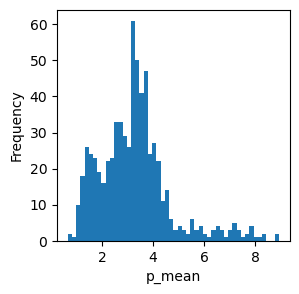

In [5]:
plot_histogram_of_data(df, attribute)

## Test a hypothesis that the data are normal
We'll never have access to all the data. So let's choose a subset of data to sample, then explore both the sample and the full population. Also, we need to set some threshold value to accept our hypothesis, before we begin.

In [6]:
K_samples = 150
beta_value = 0.15 # Value which the KS test has to be under to accept normality of the distribution

### Sample a target variable with some defined number of random catchments

In [7]:
def get_data_and_sample_data(df, K_samples, attribute):
    sample_catchments = np.random.choice(df.index.values, K_samples)
    d = df.loc[:, attribute]
    d_sample = df.loc[sample_catchments, attribute]
    return d, d_sample

In [8]:
d, d_sample = get_data_and_sample_data(df, K_samples, attribute)

### Save the statistics values for the sample and full population

In [9]:
def get_statistics_from_data(d, d_sample):
    d_stats = [np.average(d), np.std(d), skew(d), kurtosis(d), np.var(d)]
    d_sample_stats = [np.average(d_sample), np.std(d_sample), skew(d_sample), kurtosis(d_sample), np.var(d_sample)]
    return d_stats, d_sample_stats

In [10]:
d_stats, d_sample_stats = get_statistics_from_data(d, d_sample)

### Print the mean and confidence intervals of the sample
Comparing to the full population mean, which should be inside the confidence interval, depending on the sample size and confidence

In [11]:
def print_sample_mean_and_confidence_intervals(d, d_sample, confidence):
    n = len(d_sample)
    se = stats.sem(d_sample)
    m = np.mean(d_sample)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    print(f'Lower 90% CI {m-h:.2f}')
    print(f'Sample mean {m:.2f}')
    print(f'Upper 90% CI {m+h:.2f}')
    print(f'True mean {np.mean(d):.2f}')

In [12]:
print_sample_mean_and_confidence_intervals(d, d_sample, confidence = 0.5)

Lower 90% CI 3.29
Sample mean 3.37
Upper 90% CI 3.45
True mean 3.26


### We want some evenly spaced data spanning some sigma value to use in plotting

In [13]:
def get_x_values(d_stats, d_sample_stats, sigma=4):
    x = np.linspace(d_stats[0] - sigma*d_stats[1], 
                    d_stats[0] + sigma*d_stats[1], 10000)
    x_sample = np.linspace(d_sample_stats[0] - sigma*d_sample_stats[1], 
                           d_sample_stats[0] + sigma*d_sample_stats[1], 10000)
    return x, x_sample

In [14]:
x, x_sample = get_x_values(d_stats, d_sample_stats)

### Generate some synthetic normal data with the states we've calculated

In [15]:
def get_y_values(x, x_sample, d_stats, d_sample_stats):
    y = stats.norm.pdf(x, d_stats[0], d_stats[1])
    y_sample = stats.norm.pdf(x_sample, d_sample_stats[0], d_sample_stats[1])
    return y, y_sample

In [16]:
y, y_sample = get_y_values(x, x_sample, d_stats, d_sample_stats)

### Compare the distributions from the population and sample

In [17]:
def plot_sample_and_population_distributions(x, x_sample, y, y_sample, attribute):
    fig, axs = plt.subplots(figsize=(3,3))
    axs.plot(x, y, c='blue', label="All catchments")
    axs.plot(x_sample, y_sample, c='green', label="sample")
    axs.set_ylabel("Probability")
    axs.set_xlabel(attribute)
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.show()
    plt.close()

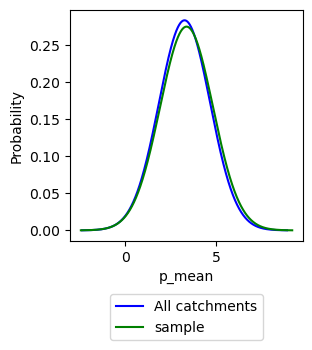

In [18]:
plot_sample_and_population_distributions(x, x_sample, y, y_sample, attribute)

### Check for normality with a Kalmogorov-Smirnov test

In [19]:
def are_the_data_normal(data, beta_value):
    d_n = (data - np.mean(data)) / np.std(data)
    kstest_result = stats.kstest(d_n, 'norm')
    if kstest_result[0] < beta_value:
        print("The data are normal")
    else:
        print("The data are NOT normal")
    print(kstest_result)
    return(kstest_result[0], kstest_result[1])


##### Now let's check our sample

In [20]:
ks_stat, p_value = are_the_data_normal(d_sample, beta_value)

The data are normal
KstestResult(statistic=0.134946097568712, pvalue=0.007638551412643572, statistic_location=0.2319731582539855, statistic_sign=1)


### Plot the cumulative probability distribution of the sample, population and sythetic data

In [21]:
def plot_cumulative_distributions_population_sample_and_synthetic(d, 
                                                                  d_stats, 
                                                                  d_sample, 
                                                                  d_sample_stats, 
                                                                  attribute):
    v01, b01 = np.histogram(np.random.normal(d_stats[0], d_stats[1],100000), bins=10000)
    v02, b02 = np.histogram(np.random.normal(d_sample_stats[0], d_sample_stats[1],100000), bins=10000)
    v1, b1 = np.histogram(d, bins=20)
    v2, b2 = np.histogram(d_sample, bins=20)
    v01 = v01/np.max(v01)
    v02 = v02/np.max(v02)
    v1 = v1/np.max(v1)
    v2 = v2/np.max(v2)
    c01 = np.cumsum(v01)
    c02 = np.cumsum(v02)
    c1 = np.cumsum(v1)
    c2 = np.cumsum(v2)

    fig, axs = plt.subplots(figsize=(3,4))
    axs.plot(b01[:-1], c01/np.max(c01), c='k', label="Synthetic population data")
    axs.plot(b02[:-1], c02/np.max(c02), "--", c='k', label="Synthetic sample data")
    axs.plot(b1[:-1], c1/c1[-1], c='blue', label="All catchments")
    axs.plot(b2[:-1], c2/c2[-1], c='green', label="Sampled catchments")
    axs.grid(color='grey', linestyle='-', linewidth=0.1)
    axs.set_ylabel("Cumulative probability \n (exceedence)")
    axs.set_xlabel(attribute)
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
    plt.tight_layout()
    plt.show()
    plt.close()

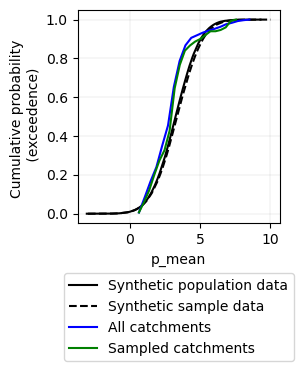

In [22]:
plot_cumulative_distributions_population_sample_and_synthetic(d, d_stats, d_sample, d_sample_stats, attribute)

# Make a big function to do all the above
With this single function, it will be easier to loop through all our basin attributes

In [23]:
def explore_attribute_distribution(df, attribute, K_samples, confidence):
    
    print("\n ---------------------------------")
    print(f"Exploring distribution of {attribute}")
    
    plot_histogram_of_data(df, attribute)
    
    d, d_sample = get_data_and_sample_data(df, K_samples, attribute)
    
    d_stats, d_sample_stats = get_statistics_from_data(d, d_sample)
    
    print_sample_mean_and_confidence_intervals(d, d_sample, confidence=confidence)
    
    x, x_sample = get_x_values(d_stats, d_sample_stats)
    
    y, y_sample = get_y_values(x, x_sample, d_stats, d_sample_stats)
    
    plot_sample_and_population_distributions(x, x_sample, y, y_sample, attribute)
    
    ks_stat, p_value = are_the_data_normal(d_sample, beta_value)

    plot_cumulative_distributions_population_sample_and_synthetic(d, d_stats, d_sample, d_sample_stats, attribute)

# Loop through all the attributes to inspect all the distributions


 ---------------------------------
Exploring distribution of p_mean


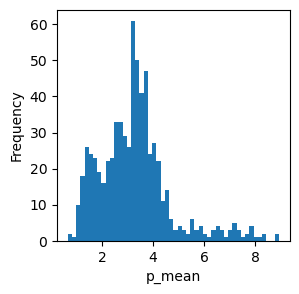

Lower 90% CI 3.20
Sample mean 3.55
Upper 90% CI 3.90
True mean 3.26


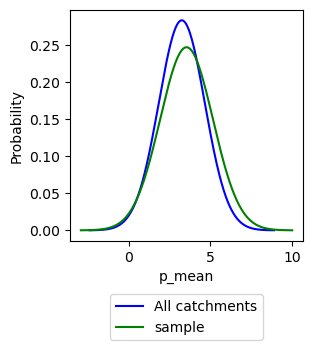

The data are NOT normal
KstestResult(statistic=0.1768855537707249, pvalue=0.04105939244792667, statistic_location=0.27007254834096894, statistic_sign=1)


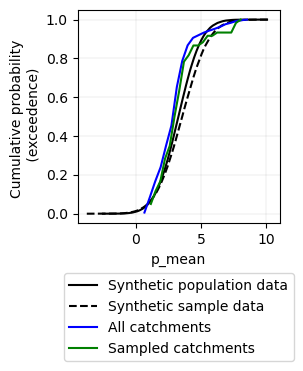


 ---------------------------------
Exploring distribution of pet_mean


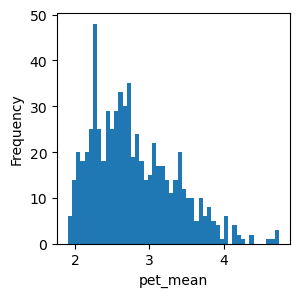

Lower 90% CI 2.69
Sample mean 2.80
Upper 90% CI 2.91
True mean 2.79


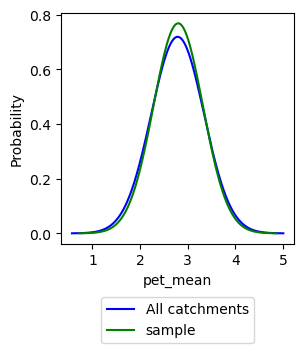

The data are normal
KstestResult(statistic=0.12824614993672956, pvalue=0.2545938446097763, statistic_location=-0.8235868210265632, statistic_sign=1)


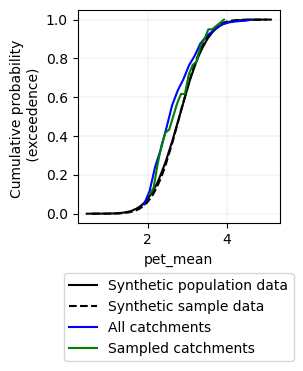


 ---------------------------------
Exploring distribution of p_seasonality


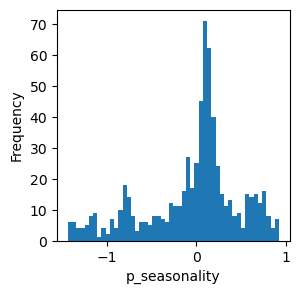

Lower 90% CI -0.25
Sample mean -0.13
Upper 90% CI -0.01
True mean -0.04


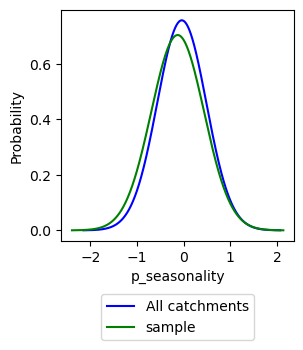

The data are NOT normal
KstestResult(statistic=0.16607816337953363, pvalue=0.06480825190556005, statistic_location=0.16639809472705078, statistic_sign=-1)


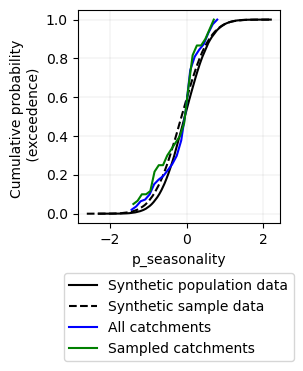


 ---------------------------------
Exploring distribution of frac_snow


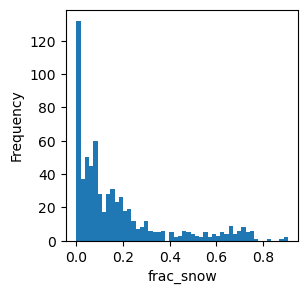

Lower 90% CI 0.14
Sample mean 0.19
Upper 90% CI 0.24
True mean 0.18


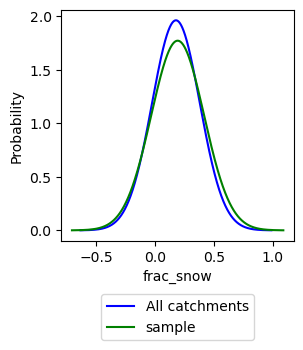

The data are NOT normal
KstestResult(statistic=0.22522457023135645, pvalue=0.0037216783573810197, statistic_location=-0.14731398703152954, statistic_sign=1)


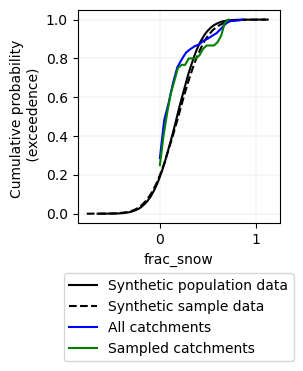

In [24]:
for i, attribute in enumerate(df.columns.values):
    explore_attribute_distribution(df, attribute, 60, confidence = 0.9)
    if i > 2:
        break

##### Check some fake data that we know are normal
Notice that with a relatively small sample (less than 1000), it is actually kind of hard to get a low KS test score.

In [25]:
data_normal = stats.norm.rvs(size=50,loc=0,scale=1)
ks_stat, p_value = are_the_data_normal(data_normal, beta_value)

The data are normal
KstestResult(statistic=0.08341230095284952, pvalue=0.848868438965131, statistic_location=-0.7837694579545027, statistic_sign=1)


# What about join probability distributions?

In [26]:
def plot_join_probability(df, attribute1, attribute2):
    x = df[attribute1]
    y = df[attribute2]
    
    # Calculate the 2D histogram with density normalization
    H, xedges, yedges = np.histogram2d(x, y, bins=(50, 50), density=True)
    
    # Calculate the areas for normalization
    areas = np.matmul(np.array([np.diff(xedges)]).T, np.array([np.diff(yedges)]))
    
    # Normalize the histogram
    H_normalized = H * areas
    
    fig = plt.figure(figsize=(6, 6))
    im = plt.imshow(H_normalized, interpolation='nearest', origin='lower',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
    plt.colorbar(im)
    plt.xlabel(attribute1)
    plt.ylabel(attribute2)
    plt.title(f'Joint Probability Density of {attribute1} and {attribute2}')
    plt.show()

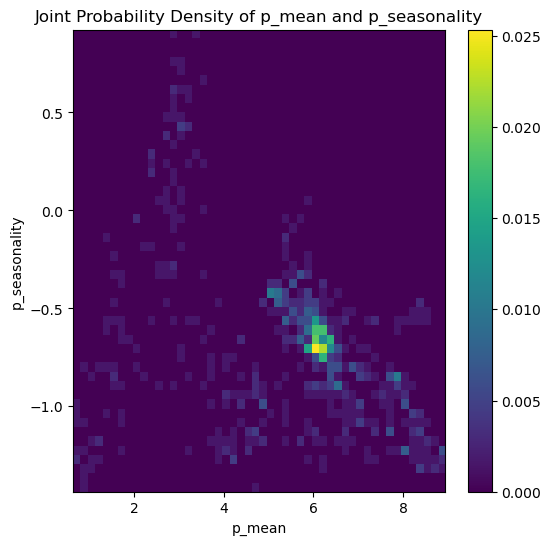

In [27]:
plot_join_probability(df,"p_mean","p_seasonality")